# Generative Adversarial Networks

Let's try to understand these guys


Network1:

z -> G -> fake -> D -> out1

Network2:

x -> D -> out2

D tries to make out1 near 0 and out2 near 1
G tries to make out1 near 1

Alternate training D and G by training networks 1 and 2.




In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

Generally accepted practice is that your generator should train at a slightly slower rate than your discriminator.
This may help with "mode collapse" which we will see shortly.

In [39]:
# Change these as you see fit
noise_dim       = 1
batch_size      = 128
steps_per_epoch = 100
epochs          = 50
data_dim        = 1
optimizer_d       = Adam(0.002, 0.5)
optimizer_g       = Adam(0.001, 0.5)

A common problem with GANS is "vanishing gradients", where the gradient wrt genereator parameter changes goes to zero.
One way of mitigating this is by using the "LeakyReLU" activation function.

Recall that a ReLU is defined as:

$f(x) = x^+ = \max(0,x)$

This function is totally flat for $x < 0$, and consequently can squash out a gradient completely.
To overcome this, we use the LeakyReLU, defined as:

$
 f(x)= \left\{
            \begin{array}{ll}
                x & \mathrm{if} & x > 0 \\
                \alpha x & \mathrm{otherwise} \\
            \end{array} 
        \right.
$

In [40]:
# Generator network
# You can play with the number of layers and the depth of each layer
# To me, LeakyReLu worked better than ReLU. Seems to need to have
# non flat areas to get gradients to work well
def create_generator():
    G = Sequential()
    
    G.add(Dense(20, input_dim=noise_dim))
    G.add(LeakyReLU(0.3))
    G.add(Dense(20))
    G.add(LeakyReLU(0.3))
    G.add(Dense(20))
    G.add(LeakyReLU(0.3))
    G.add(Dense(data_dim, activation='linear'))
    
    # Binary crossentropy does the log business
    G.compile(loss='binary_crossentropy', optimizer=optimizer_g)
    return G

# Apparently this needs to be clever so deeper?
def create_descriminator():
    D = Sequential()
     
    D.add(Dense(10, input_dim=data_dim))
    D.add(LeakyReLU(0.2))
    D.add(Dense(10))
    D.add(LeakyReLU(0.2))
    D.add(Dense(10))
    D.add(LeakyReLU(0.2))
    D.add(Dense(10))
    D.add(LeakyReLU(0.2))
    D.add(Dense(1, activation='sigmoid'))
    
    D.compile(loss='binary_crossentropy', optimizer=optimizer_d)
    return D


### Here we actually create D and G
 There is just one trick with D.trainable=False
 This tells keras to not touch D when training the combined model

In [41]:
D = create_descriminator()
G = create_generator()

D.trainable = False

gan_input  = Input(shape=(noise_dim,))
Fake       = G(gan_input)

gan_output = D(Fake)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer_g)

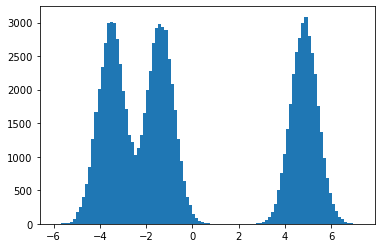

In [6]:

# Create some data with three bumps 

n     = 100000
A     = np.random.random((data_dim,data_dim))
cov   = A.T@A
mu1   = np.random.randn(data_dim)
mu2   = np.random.randn(data_dim)+5
mu3   = np.random.randn(data_dim)-5
data1 = np.random.multivariate_normal(mu1,cov,int(n/3))
data2 = np.random.multivariate_normal(mu2,cov,int(n/3)) 
data3 = np.random.multivariate_normal(mu3,cov,int(n/3)) 
data  = np.concatenate((data1,data2,data3),axis=0)

_ = plt.hist(data,100)

One last trick here, instead of using a label of 1 for our real data, we use 0.9 - this again helps with our "vanishing gradient problem"

In [42]:
# Training

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        # random noise realisation
        z = np.random.uniform(0, 1, size=(batch_size, noise_dim))
        # fake data = G(z)
        fake_x = G.predict(z)
        # real data = some batch of data
        real_x = data[np.random.randint(0, data.shape[0], size=batch_size)]
        # concatenate real and fake data
        x = np.concatenate((real_x, fake_x))

        # target for D
        y_D = np.zeros(2*batch_size)
        y_D[:batch_size] = 0.9   # D=1 for real

        # train D
        D_loss = D.train_on_batch(x, y_D)

        # target for G is all 1's for noise        
        y_G = np.ones(batch_size)*0.9
        
        # train G
        G_loss = gan.train_on_batch(z, y_G)
    
   

    print(f'Epoch: {epoch} \t Discriminator Loss: {D_loss} \t\t Generator Loss: {G_loss}')



Epoch: 0 	 Discriminator Loss: 0.5928377509117126 		 Generator Loss: 1.024935007095337


2022-03-10 10:33:59.523300: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:33:59.682436: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 1 	 Discriminator Loss: 0.6839443445205688 		 Generator Loss: 0.790123462677002
Epoch: 2 	 Discriminator Loss: 0.6792693138122559 		 Generator Loss: 0.8154799938201904
Epoch: 3 	 Discriminator Loss: 0.6797400116920471 		 Generator Loss: 0.8080084919929504
Epoch: 4 	 Discriminator Loss: 0.6673558950424194 		 Generator Loss: 0.8058301210403442
Epoch: 5 	 Discriminator Loss: 0.6615322232246399 		 Generator Loss: 0.8958383202552795
Epoch: 6 	 Discriminator Loss: 0.6492279767990112 		 Generator Loss: 0.901972770690918
Epoch: 7 	 Discriminator Loss: 0.6040704250335693 		 Generator Loss: 1.0080018043518066
Epoch: 8 	 Discriminator Loss: 0.6320651769638062 		 Generator Loss: 0.9534847736358643
Epoch: 9 	 Discriminator Loss: 0.6364983320236206 		 Generator Loss: 0.8920824527740479
Epoch: 10 	 Discriminator Loss: 0.6222800612449646 		 Generator Loss: 0.9465636014938354
Epoch: 11 	 Discriminator Loss: 0.654135525226593 		 Generator Loss: 0.8922766447067261
Epoch: 12 	 Discriminator Loss: 0

2022-03-10 10:35:03.376014: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 14 	 Discriminator Loss: 0.6714491248130798 		 Generator Loss: 0.8277724981307983


2022-03-10 10:35:09.736022: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 15 	 Discriminator Loss: 0.6918655037879944 		 Generator Loss: 0.826282262802124


2022-03-10 10:35:13.894226: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 16 	 Discriminator Loss: 0.6931947469711304 		 Generator Loss: 0.7760823965072632
Epoch: 17 	 Discriminator Loss: 0.6815652847290039 		 Generator Loss: 0.7849823236465454


2022-03-10 10:35:23.360015: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 18 	 Discriminator Loss: 0.6731380224227905 		 Generator Loss: 0.8404436707496643
Epoch: 19 	 Discriminator Loss: 0.6894869804382324 		 Generator Loss: 0.7793821692466736
Epoch: 20 	 Discriminator Loss: 0.687027096748352 		 Generator Loss: 0.7626100182533264
Epoch: 21 	 Discriminator Loss: 0.6827930808067322 		 Generator Loss: 0.7847055196762085
Epoch: 22 	 Discriminator Loss: 0.6836429834365845 		 Generator Loss: 0.7710733413696289


2022-03-10 10:35:47.962685: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 23 	 Discriminator Loss: 0.6806641221046448 		 Generator Loss: 0.837119996547699
Epoch: 24 	 Discriminator Loss: 0.6825563907623291 		 Generator Loss: 0.7868218421936035


2022-03-10 10:35:54.409179: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:35:54.618881: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:35:58.708031: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 25 	 Discriminator Loss: 0.6863014698028564 		 Generator Loss: 0.7868711948394775


2022-03-10 10:36:01.143364: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:04.186355: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 26 	 Discriminator Loss: 0.6938044428825378 		 Generator Loss: 0.7702852487564087


2022-03-10 10:36:06.861327: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:07.245924: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:10.700028: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 27 	 Discriminator Loss: 0.6773210763931274 		 Generator Loss: 0.8211821913719177
Epoch: 28 	 Discriminator Loss: 0.6796108484268188 		 Generator Loss: 0.8382375240325928


2022-03-10 10:36:18.029087: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:19.664015: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:22.283455: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 29 	 Discriminator Loss: 0.6731330156326294 		 Generator Loss: 0.8520854711532593


2022-03-10 10:36:26.155979: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:26.450140: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:26.620021: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:26.628052: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:27.492014: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 30 	 Discriminator Loss: 0.6905851364135742 		 Generator Loss: 0.7860041260719299


2022-03-10 10:36:32.938994: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 31 	 Discriminator Loss: 0.6743143796920776 		 Generator Loss: 0.8047010898590088
Epoch: 32 	 Discriminator Loss: 0.6838045716285706 		 Generator Loss: 0.794350266456604


2022-03-10 10:36:41.960843: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 33 	 Discriminator Loss: 0.6798377633094788 		 Generator Loss: 0.7554117441177368


2022-03-10 10:36:46.295089: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:49.819838: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:49.984462: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 34 	 Discriminator Loss: 0.688351035118103 		 Generator Loss: 0.8109701871871948


2022-03-10 10:36:52.151230: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 35 	 Discriminator Loss: 0.6855857372283936 		 Generator Loss: 0.7955700755119324


2022-03-10 10:36:57.896021: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:36:59.451158: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:01.691150: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 36 	 Discriminator Loss: 0.6723368167877197 		 Generator Loss: 0.8225921392440796


2022-03-10 10:37:07.195642: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 37 	 Discriminator Loss: 0.6757656931877136 		 Generator Loss: 0.8010995388031006


2022-03-10 10:37:08.764017: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:12.132090: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:14.652039: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 38 	 Discriminator Loss: 0.6824579834938049 		 Generator Loss: 0.8153992891311646


2022-03-10 10:37:16.276034: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 39 	 Discriminator Loss: 0.6828165650367737 		 Generator Loss: 0.8160266876220703
Epoch: 40 	 Discriminator Loss: 0.6803492903709412 		 Generator Loss: 0.8029842376708984
Epoch: 41 	 Discriminator Loss: 0.690416693687439 		 Generator Loss: 0.7883595824241638
Epoch: 42 	 Discriminator Loss: 0.6768477559089661 		 Generator Loss: 0.8479204177856445


2022-03-10 10:37:39.259611: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:39.479846: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 43 	 Discriminator Loss: 0.6795422434806824 		 Generator Loss: 0.8121642470359802


2022-03-10 10:37:45.928021: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:46.564061: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:47.632043: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 44 	 Discriminator Loss: 0.6801056861877441 		 Generator Loss: 0.8133935332298279


2022-03-10 10:37:50.036860: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 45 	 Discriminator Loss: 0.6846089959144592 		 Generator Loss: 0.8022791147232056


2022-03-10 10:37:55.952089: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:56.330321: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:57.711528: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:58.960032: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:59.911165: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:37:59.992029: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:38:00.432752: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:38:00.978159: W tensorflow/core/data/root_dataset.cc:16

Epoch: 46 	 Discriminator Loss: 0.6987619400024414 		 Generator Loss: 0.8010340332984924


2022-03-10 10:38:08.406787: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:38:08.764043: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 47 	 Discriminator Loss: 0.6800981760025024 		 Generator Loss: 0.7771663069725037


2022-03-10 10:38:09.684989: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 10:38:09.826518: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 48 	 Discriminator Loss: 0.6687040328979492 		 Generator Loss: 0.8613372445106506
Epoch: 49 	 Discriminator Loss: 0.6789753437042236 		 Generator Loss: 0.8252822160720825


# Optimal Discriminator

It turns out that there is a known form for the optimal discriminator:

$D^*(x) = \frac{p_{real}(x)}{p_{real}(x) + p_{fake}(x)}$

This is optimal in the sense that it minimises our discriminator loss, NOT that it always gets the prediction right!

Let's look at some predictions then:

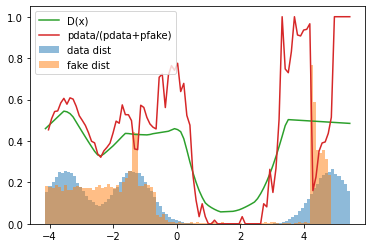

In [43]:
# Compare data distrib to G distribution
# Also overlay D(x)
# Also overlay pdata/(pdata+pfake)

bins = np.linspace(np.quantile(data,.05),np.quantile(data,.95),100)
pdata,_,_ = plt.hist(data,bins=bins,density=True,alpha=.5)
pdata = pdata/np.sum(pdata)
z = np.random.uniform(0,1,10000)
Gz = G.predict(z)

pfake,_,_ = plt.hist(Gz,bins=bins,density=True,alpha=.5)
pfake = pfake/np.sum(pfake)

plt.plot(bins,D.predict(bins))
plt.plot(bins[1:],pdata/(pdata+pfake))

plt.legend(['D(x)','pdata/(pdata+pfake)','data dist','fake dist'])


# Results

Depending on how your training went, you might see a result similar to one of the following:

## Mode Collapse 1

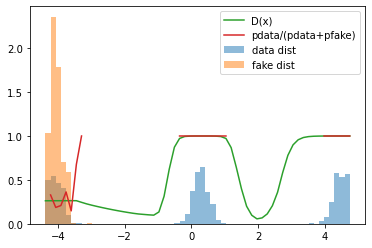

This is a clear example of "mode collapse".
The generator has found one mode of the true data distribution and is now consistantly predicting that, because it gets rewarded when it does, and penalised when it tries to move to the other modes.

## Mode Collapse 2

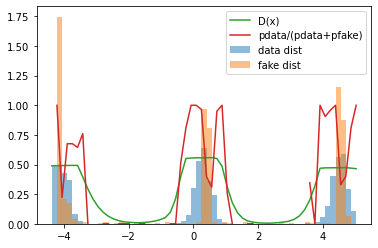

This is a more subtle example of mode collapse, where we still get predictions from all three modes, but the network has only really learnt a few examples of each mode and keeps predicting them over and over again.

## Success

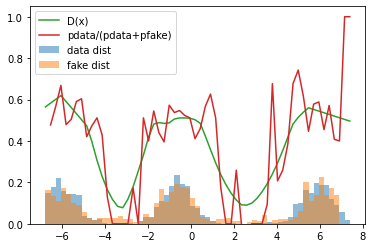

A successfully trained GAN should show examples that closely match the distribution of the true data.
At convergence we would expect D(x) to take on a value of 0.5 wherever the true data distribution is non-zero.
Looking at the upper and lower ends of this figure, we can see that the network hasn't quite converged yet.
In fact, this is a common situation when training a GAN and is often caused by the vanishing gradient problem.
Note, howevever, that the discriminator has learnt a function which approximates the ideal discriminator quite well!

# Stabilising GAN training

A modification to the simple GAN architecture called the "Wasserstein" GAN can help overcome some of the issues seen above.
In this instance the discriminator is replaced by a "critic".
Think of this as an art critic, a low output means they are not very critical of the art because it looks real, and a high out put means it is very critical of the art because it looks fake.

Training the critic encourages outputting a large difference between real and fake images.
This then creates larger gradients for training the generator, even if the critic has become "optimal".

Let's have a look:

In [56]:
from tensorflow.keras import backend
 
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

optimizer_wd       = RMSprop(0.0005)
optimizer_wg       = RMSprop(0.0005)

As we no longer want to constrain the output of the critic, we change its activation function from sigmoid to linear.

In [57]:
def create_w_generator():
    Gw = Sequential()
    
    Gw.add(Dense(20, input_dim=noise_dim))
    Gw.add(LeakyReLU(0.3))
    Gw.add(Dense(20))
    Gw.add(LeakyReLU(0.3))
    Gw.add(Dense(20))
    Gw.add(LeakyReLU(0.3))
    Gw.add(Dense(data_dim, activation='linear'))
    
    # Binary crossentropy does the log business
    Gw.compile(loss=wasserstein_loss, optimizer=optimizer_wg)
    return Gw

# Apparently this needs to be clever so deeper?
def create_w_descriminator():
    Dw = Sequential()
     
    Dw.add(Dense(10, input_dim=data_dim))
    Dw.add(LeakyReLU(0.2))
    Dw.add(Dense(10))
    Dw.add(LeakyReLU(0.2))
    Dw.add(Dense(10))
    Dw.add(LeakyReLU(0.2))
    Dw.add(Dense(10))
    Dw.add(LeakyReLU(0.2))
    Dw.add(Dense(1, activation='linear'))
    
    Dw.compile(loss=wasserstein_loss, optimizer=optimizer_wd)
    return Dw

In [58]:
Dw = create_w_descriminator()
Gw = create_w_generator()

Dw.trainable = False

gan_input_w  = Input(shape=(noise_dim,))
Fake_w       = Gw(gan_input_w)

gan_output_w = Dw(Fake_w)

gan_w = Model(gan_input_w, gan_output_w)
gan_w.compile(loss=wasserstein_loss, optimizer=optimizer_wg)

The final change is that our labels for real/fake change from 1/0 to 1/-1!

In [74]:
# Training

Dx  = np.zeros(epochs)
DGz = np.zeros(epochs)
for epoch in range(epochs):
    # target for D
    y_D = np.zeros(2*batch_size)
    y_D[:batch_size] = 1   # D=1 for real
    y_D[batch_size:] = -1   # D=-1 for fake

    # target for G is all 1's for noise        
    y_G = np.ones(batch_size)
    for batch in range(steps_per_epoch):
        # train D
        for i in range(5):
            # random noise realisation
            z = np.random.uniform(0, 1, size=(batch_size, noise_dim))
            # fake data = G(z)
            fake_x = Gw.predict(z)
            # real data = some batch of data
            real_x = data[np.random.randint(0, data.shape[0], size=batch_size)]
            # concatenate real and fake data
            x = np.concatenate((real_x, fake_x))

            D_loss = Dw.train_on_batch(x, y_D)
            for l in Dw.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -0.1, 0.1) for w in weights]
                l.set_weights(weights)
                
        # random noise realisation
        z = np.random.uniform(0, 1, size=(batch_size, noise_dim))
        
        # train G
        G_loss = gan_w.train_on_batch(z, y_G)
    
   

    print(f'Epoch: {epoch} \t Discriminator Loss: {D_loss} \t\t Generator Loss: {G_loss}')

2022-03-10 11:31:26.819719: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:31:30.359784: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 0 	 Discriminator Loss: -0.0005809830036014318 		 Generator Loss: -0.033465489745140076
Epoch: 1 	 Discriminator Loss: -0.0002862614346668124 		 Generator Loss: -0.03505486994981766


2022-03-10 11:31:45.711812: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 2 	 Discriminator Loss: -0.00038501046947203577 		 Generator Loss: -0.03443493694067001


2022-03-10 11:31:52.463363: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 3 	 Discriminator Loss: -0.000530844961758703 		 Generator Loss: -0.03706709295511246


2022-03-10 11:31:54.096081: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 4 	 Discriminator Loss: -0.00028049672255292535 		 Generator Loss: -0.03497067838907242
Epoch: 5 	 Discriminator Loss: -0.00026388850528746843 		 Generator Loss: -0.02941983938217163


2022-03-10 11:32:12.300127: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 6 	 Discriminator Loss: -0.00021598683088086545 		 Generator Loss: -0.03923332318663597


2022-03-10 11:32:15.008018: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 7 	 Discriminator Loss: -0.0002138711279258132 		 Generator Loss: -0.03224145993590355
Epoch: 8 	 Discriminator Loss: 0.0005586172337643802 		 Generator Loss: -0.03286648169159889
Epoch: 9 	 Discriminator Loss: -0.0002695008006412536 		 Generator Loss: -0.036535270512104034
Epoch: 10 	 Discriminator Loss: -0.0003927922807633877 		 Generator Loss: -0.03568388521671295
Epoch: 11 	 Discriminator Loss: -0.00016600725939497352 		 Generator Loss: -0.034023769199848175


2022-03-10 11:32:51.728031: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:32:56.940025: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 12 	 Discriminator Loss: -0.0004845413495786488 		 Generator Loss: -0.03443470969796181
Epoch: 13 	 Discriminator Loss: 4.812849510926753e-05 		 Generator Loss: -0.036816298961639404


2022-03-10 11:33:05.252351: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 14 	 Discriminator Loss: -0.00010886804375331849 		 Generator Loss: -0.03353577107191086


2022-03-10 11:33:13.432074: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:33:15.788073: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 15 	 Discriminator Loss: 0.00010182824917137623 		 Generator Loss: -0.038301847875118256


2022-03-10 11:33:19.227331: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 16 	 Discriminator Loss: -0.0004887009272351861 		 Generator Loss: -0.035710833966732025
Epoch: 17 	 Discriminator Loss: 0.000181529248948209 		 Generator Loss: -0.04245553910732269
Epoch: 18 	 Discriminator Loss: -0.00045607861829921603 		 Generator Loss: -0.03954854607582092
Epoch: 19 	 Discriminator Loss: -8.690057438798249e-05 		 Generator Loss: -0.03873705863952637
Epoch: 20 	 Discriminator Loss: -0.00013396998110692948 		 Generator Loss: -0.037580788135528564


2022-03-10 11:33:52.043418: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:33:55.850703: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 21 	 Discriminator Loss: -0.0002664687344804406 		 Generator Loss: -0.035186633467674255
Epoch: 22 	 Discriminator Loss: -0.00010073580779135227 		 Generator Loss: -0.03427113592624664
Epoch: 23 	 Discriminator Loss: -0.0013253623619675636 		 Generator Loss: -0.030562441796064377


2022-03-10 11:34:16.241096: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 24 	 Discriminator Loss: -0.0007382163894362748 		 Generator Loss: -0.03677136078476906
Epoch: 25 	 Discriminator Loss: -0.0001245577441295609 		 Generator Loss: -0.03476444631814957


2022-03-10 11:34:28.712740: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:34:29.964028: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:34:31.940029: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:34:32.508082: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 26 	 Discriminator Loss: -0.0002309265692019835 		 Generator Loss: -0.033619850873947144


2022-03-10 11:34:35.924069: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 27 	 Discriminator Loss: -0.00011217978317290545 		 Generator Loss: -0.037655141204595566
Epoch: 28 	 Discriminator Loss: -0.00017806854157242924 		 Generator Loss: -0.03516056388616562
Epoch: 29 	 Discriminator Loss: -2.053941716440022e-05 		 Generator Loss: -0.036067210137844086
Epoch: 30 	 Discriminator Loss: -1.2045071343891323e-05 		 Generator Loss: -0.040492936968803406
Epoch: 31 	 Discriminator Loss: -7.428346725646406e-05 		 Generator Loss: -0.044466882944107056
Epoch: 32 	 Discriminator Loss: -0.00028901081532239914 		 Generator Loss: -0.04105360060930252


2022-03-10 11:35:14.315445: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 33 	 Discriminator Loss: -0.00042753765592351556 		 Generator Loss: -0.03754005581140518


2022-03-10 11:35:17.712013: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 34 	 Discriminator Loss: -0.00021386469597928226 		 Generator Loss: -0.03648313134908676
Epoch: 35 	 Discriminator Loss: -0.0003371886268723756 		 Generator Loss: -0.03455647453665733
Epoch: 36 	 Discriminator Loss: -0.0002310230047442019 		 Generator Loss: -0.034909460693597794


2022-03-10 11:35:44.521373: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:35:45.941793: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 37 	 Discriminator Loss: -0.00024431583005934954 		 Generator Loss: -0.039337433874607086


2022-03-10 11:35:51.696086: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:35:53.060069: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:35:53.428079: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:35:54.043294: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 38 	 Discriminator Loss: 9.62649064604193e-05 		 Generator Loss: -0.042790599167346954


2022-03-10 11:35:56.359931: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 39 	 Discriminator Loss: 3.454033867456019e-05 		 Generator Loss: -0.044221386313438416
Epoch: 40 	 Discriminator Loss: 0.0003072404651902616 		 Generator Loss: -0.03631006181240082
Epoch: 41 	 Discriminator Loss: 5.684206553269178e-05 		 Generator Loss: -0.0399554967880249


2022-03-10 11:36:18.088044: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:36:20.208073: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 42 	 Discriminator Loss: -0.00044918758794665337 		 Generator Loss: -0.04389084503054619


2022-03-10 11:36:24.196076: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 43 	 Discriminator Loss: -9.79330507107079e-05 		 Generator Loss: -0.040697962045669556


2022-03-10 11:36:30.624030: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:36:30.679395: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:36:31.775737: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:36:33.640038: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 44 	 Discriminator Loss: -0.00012134264397900552 		 Generator Loss: -0.03665148839354515


2022-03-10 11:36:36.767823: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 45 	 Discriminator Loss: -0.0006851928774267435 		 Generator Loss: -0.033724043518304825
Epoch: 46 	 Discriminator Loss: -0.00012402478023432195 		 Generator Loss: -0.038245514035224915


2022-03-10 11:36:52.080319: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 47 	 Discriminator Loss: -9.434495586901903e-05 		 Generator Loss: -0.039156023412942886


2022-03-10 11:36:58.688019: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 48 	 Discriminator Loss: -0.00015446334145963192 		 Generator Loss: -0.04088600352406502


2022-03-10 11:37:03.408025: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:37:04.847306: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-10 11:37:06.140056: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 49 	 Discriminator Loss: 0.0006311578908935189 		 Generator Loss: -0.04038621485233307


If we plot the data, we can now see that our generator is hopefully consistently producing samples fairly evenly from all 3 modes!

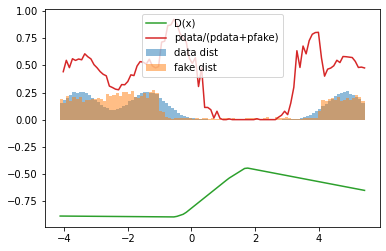

In [75]:
# Compare data distrib to G distribution
# Also overlay D(x)
# Also overlay pdata/(pdata+pfake)

bins = np.linspace(np.quantile(data,.05),np.quantile(data,.95),100)
pdata,_,_ = plt.hist(data,bins=bins,density=True,alpha=.5)
pdata = pdata/np.sum(pdata)
z = np.random.uniform(0,1,10000)
Gz = Gw.predict(z)

pfake,_,_ = plt.hist(Gz,bins=bins,density=True,alpha=.5)
pfake = pfake/np.sum(pfake)

plt.plot(bins,20*Dw.predict(bins))
plt.plot(bins[1:],pdata/(pdata+pfake))

plt.legend(['D(x)','pdata/(pdata+pfake)','data dist','fake dist'])

Below is one example of training.
Note how the critic takes on a higher value (i.e. "more critical") of predictions where the true distribution is zero.
In other words, if it sees any values in this region is says they are probably not real.

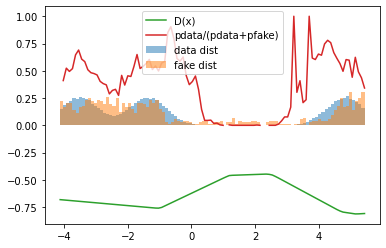